In [1]:
import pandas as pd
import random
import numpy as np
import torch
from numpy import nan
import math
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from scipy.stats import mannwhitneyu

# Overview

This notebook demonstrates the pipeline used in the Paper "A Machine Learning Approach to Incorporate Time within Inpatient Early Warning Systems."  We demonstrate this pipeline on synethetically generated vital sign data using hidden markov models.  We will go through the steps required to train our GRU-D model and evaluation against baseline Early Warning Scores (EWS) systems; Modified Early Warning Score (MEWS), electronic Cardiac Arrest Triage (eCART) and National Early Warning Score 2 (NEWS2).

The notebook is structured as:

1. Data Exploration
2. EWS Calculation
3. Pre-Processing Pipeline for Model Training
4. Assessment of All Time Points
5. Assessment of Last 24 hours
6. Assessment of Timeliness of Warnings

## Data Exploration

This synthetically generated data has 1000 episodes with a breakdown of 800 'healthy' cases and 200 'unstable' cases.  This system is designed to 'learn' patterns that resemble death/critical care admission, so we use patterns within the last 24 hours by using the label of death/critical admission within the next 24 hours. 

In [2]:
df = pd.read_csv('Data/ews_synthetic_data.csv')
df

,episode_id,age,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs
0,2000.0,65.0,382.0,120.0,76.0,47.0,37.574380,8.0,100.0,1.0,True
1,2000.0,65.0,497.0,79.0,56.0,105.0,37.999197,14.0,97.0,6.0,True
2,2000.0,65.0,621.0,81.0,61.0,113.0,38.539351,9.0,98.0,6.0,True
3,2000.0,65.0,726.0,96.0,76.0,106.0,38.026928,17.0,97.0,5.0,True
4,2000.0,65.0,851.0,92.0,76.0,101.0,37.813805,13.0,100.0,6.0,True
...,...,...,...,...,...,...,...,...,...,...,...
47120,2999.0,56.0,688.0,111.0,67.0,53.0,38.488368,9.0,100.0,0.0,False
47121,2999.0,56.0,1050.0,113.0,76.0,42.0,36.415452,12.0,99.0,1.0,False
47122,2999.0,56.0,1443.0,118.0,78.0,51.0,37.414629,6.0,99.0,0.0,False
47123,2999.0,56.0,1820.0,128.0,86.0,45.0,37.972787,5.0,99.0,2.0,False


In [3]:
df.describe()

,episode_id,age,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow
count,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000
mean,2463.964541,63.845602,11280.745549,105.149899,74.001528,77.556477,37.638715,12.472743,98.400531,2.725050
std,301.927449,8.356343,10510.218921,21.733844,12.170467,37.093601,0.514832,4.551505,1.756389,2.916729
min,2000.000000,37.000000,91.000000,37.000000,25.000000,23.000000,35.447830,1.000000,87.000000,0.000000
25%,2181.000000,58.000000,3439.000000,90.000000,68.000000,48.000000,37.294358,9.000000,98.000000,1.000000
50%,2445.000000,64.000000,8186.000000,114.000000,76.000000,56.000000,37.620647,12.000000,99.000000,1.000000
75%,2729.000000,69.000000,15805.000000,122.000000,82.000000,110.000000,37.962782,15.000000,100.000000,5.000000
max,2999.000000,94.000000,64107.000000,149.000000,111.000000,177.000000,41.051724,31.000000,100.000000,16.000000


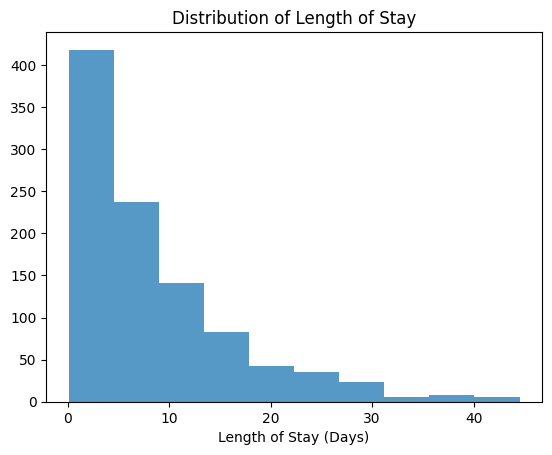

In [4]:
plt.hist(df.groupby('episode_id').max()['anchor_time']/60/24, alpha = 0.75)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (Days)')
plt.show()

The majority of episodes less than 10 days which is reflective of real-world data.

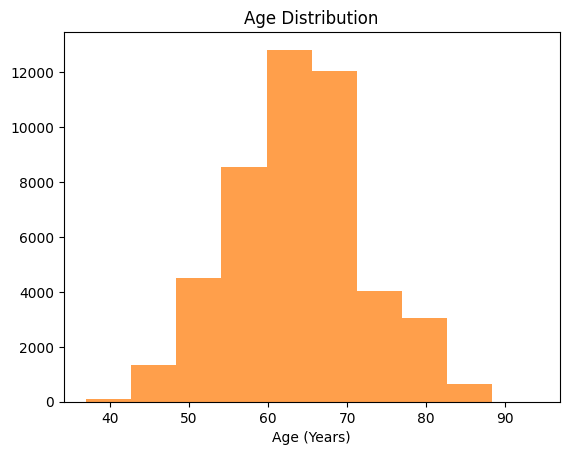

In [5]:
plt.hist(df['age'], alpha = 0.75, density= False, label= 'Age', color = 'C1')
plt.xlabel('Age (Years)')
plt.title('Age Distribution')
plt.show()

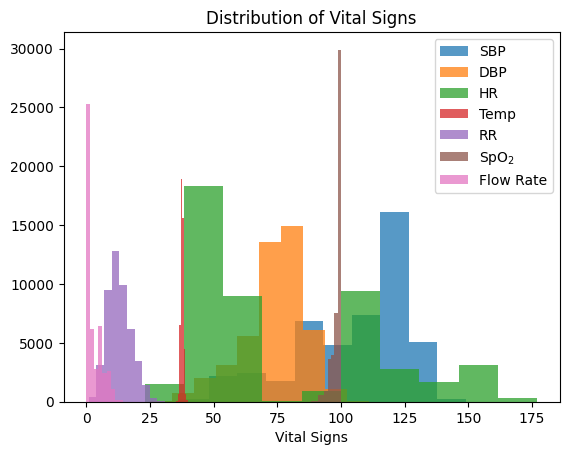

In [6]:
plt.hist(df['sbp'], alpha = 0.75, density= False, label= 'SBP')
plt.hist(df['dbp'], alpha = 0.75, density= False, label= 'DBP')
plt.hist(df['hr'], alpha = 0.75, density= False, label= 'HR')
plt.hist(df['temp'], alpha = 0.75, density= False, label= 'Temp')
plt.hist(df['rr'], alpha = 0.75, density= False, label= 'RR')
plt.hist(df['spo2'], alpha = 0.75, density= False, label= 'SpO$_2$')
plt.hist(df['flow'], alpha = 0.75, density= False, label= 'Flow Rate')
plt.xlabel('Vital Signs')
plt.legend()
plt.title('Distribution of Vital Signs')
plt.show()

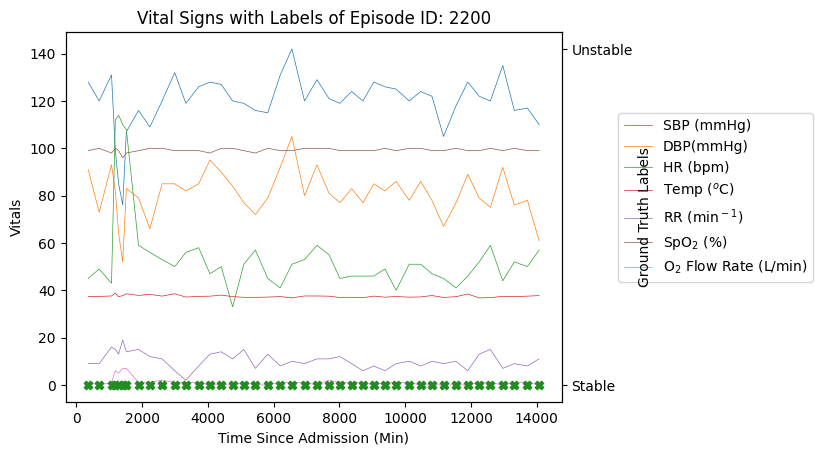

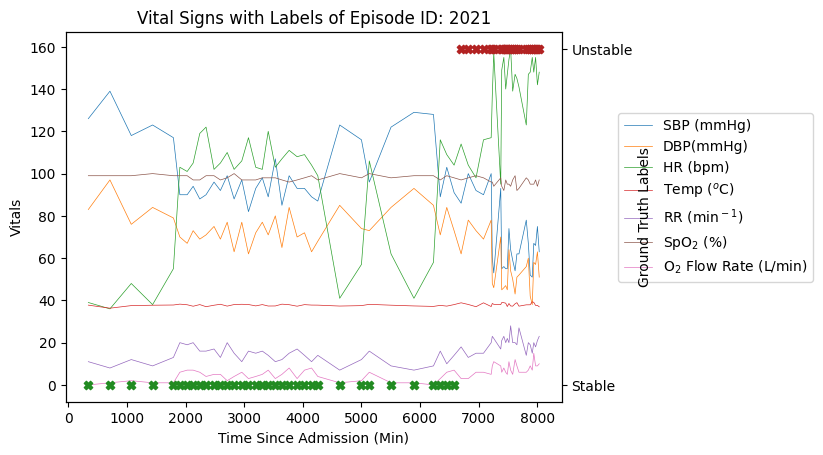

In [7]:
from plotting_func import plot_vitals_labels

plot_vitals_labels(2200, df)
plot_vitals_labels(2021, df)

Two episodes where there are different outcomes (Top stable, bottom unstable).  Each line is the time series of each vital sign with the cross marking the label of whether the patient was within 24 hours of an adverse event.

You can alter the episode_id to plot different vital signs.  Episode IDs run from 2000-2999 (unstable: 2000-2199, stable 2200-2999).

## EWS Calculation

Using the vitals signs values, we can recreate the score that each EWS would have given at each time point/observation.

In [8]:
from baseline_ews_calc import *

df['mews'] = df.apply(lambda row: mews_calc(row), axis=1)
df['ecart'] = df.apply(lambda row: cart_calc(row), axis=1)
df['news2'] = df.apply(lambda row: news_calc(row), axis=1)
df

,episode_id,age,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs,mews,ecart,news2
0,2000.0,65.0,382.0,120.0,76.0,47.0,37.574380,8.0,100.0,1.0,True,3,4,9
1,2000.0,65.0,497.0,79.0,56.0,105.0,37.999197,14.0,97.0,6.0,True,3,4,9
2,2000.0,65.0,621.0,81.0,61.0,113.0,38.539351,9.0,98.0,6.0,True,5,8,11
3,2000.0,65.0,726.0,96.0,76.0,106.0,38.026928,17.0,97.0,5.0,True,3,4,8
4,2000.0,65.0,851.0,92.0,76.0,101.0,37.813805,13.0,100.0,6.0,True,2,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47120,2999.0,56.0,688.0,111.0,67.0,53.0,38.488368,9.0,100.0,0.0,False,0,4,1
47121,2999.0,56.0,1050.0,113.0,76.0,42.0,36.415452,12.0,99.0,1.0,False,1,4,6
47122,2999.0,56.0,1443.0,118.0,78.0,51.0,37.414629,6.0,99.0,0.0,False,2,4,3
47123,2999.0,56.0,1820.0,128.0,86.0,45.0,37.972787,5.0,99.0,2.0,False,3,4,9


Text(0.5, 1.0, 'Distribution of EWS Scores')

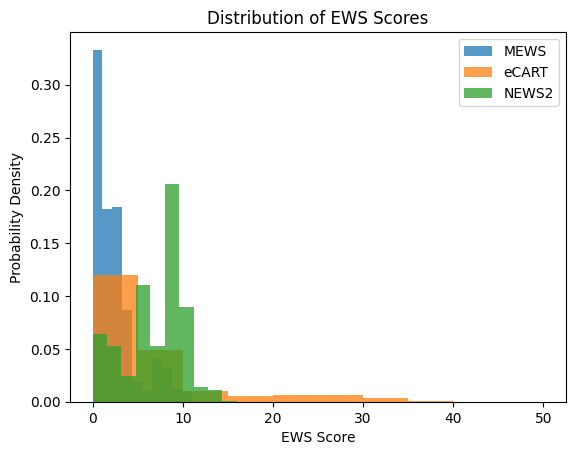

In [9]:
plt.hist(df['mews'], alpha = 0.75, density= True, label= 'MEWS')
plt.hist(df['ecart'], alpha = 0.75, density= True, label= 'eCART')
plt.hist(df['news2'], alpha = 0.75, density= True, label= 'NEWS2')
plt.xlabel('EWS Score')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Distribution of EWS Scores')

## Pipeline for Model Training

Pipeline is illustrated by the figure below.  The training/validation data is trimmed to the last 48 hours of each sequence and the test data is allowed to have the complete sequence for assessment in the real world conditions, as well as the last 24 hours to assess sequence level predictions

![Alt Text](Data/gru_ews_pipeline.png)

In [10]:
from pre_processing_func import *

# Columns for feature extraction (always the anchor_time first to allow for time context for models)
cols =[ 'anchor_time',	'sbp',	'dbp',	'hr',	'temp',	'rr',	'spo2',	'flow']

X, Y, episodes = df_to_np_pipe(df,cols,200)

# train_val_test_split has random seed set (can alter if required)
train_data, train_label, valid_data, valid_label, test_data, test_label, test_idx= train_val_test_split(X, Y)
print ('Number in Training Set', len(train_data), 'Event rate:', train_label.max(axis=1).sum()/len(train_label))
print ('Number in Validation Set', len(valid_data), 'Event rate:', valid_label.max(axis=1).sum()/len(valid_label))
print ('Number in Test Set', len(test_data), 'Event rate:', test_label.max(axis=1).sum()/len(test_label))

Number in Training Set 700 Event rate: 0.2042857142857143
Number in Validation Set 99 Event rate: 0.2222222222222222
Number in Test Set 201 Event rate: 0.17412935323383086


In [11]:
# First stage of preprocessing
# Normalises according to Training Set

# Training Set
gru_train_x, gru_train_len, gru_train_timings, X_mean, train_means, train_std, max_delta  = train_mask_delta_generator(train_data)

# Validation Set
gru_val_x, gru_val_len, gru_val_timings = val_test_mask_delta_generator(valid_data,train_means, train_std, max_delta)

# Test Set
gru_test_x, gru_test_len, gru_test_timings = val_test_mask_delta_generator(test_data,train_means, train_std, max_delta)



Start to generate Training Mask, Delta, Last_observed_X ...
Finished Training Set Pre-Processing
Start to generate Validation/Testing Mask, Delta, Last_observed_X ...
Finished Validation/Training Pre-Processing
Start to generate Validation/Testing Mask, Delta, Last_observed_X ...
Finished Validation/Training Pre-Processing


In [12]:
# Dataset compilation 

# Training and Validation datasets -> Trimmed to 48 hours
gru_train_dataset, _  = dataset_compiler_gru_shorten(gru_train_x, train_label, gru_train_len, gru_train_timings, 24, 48)
gru_val_dataset, _ = dataset_compiler_gru_shorten(gru_val_x, valid_label, gru_val_len, gru_val_timings, 24, 48)

# Dataloader loads batches of similar length to reduce padding
gru_train_dataloader = dataloader_compiler (gru_train_dataset, batch_size = 20)
gru_val_dataloader = dataloader_compiler (gru_val_dataset, batch_size = 20)

# Test Datasets for Evaluation: Long: All time steps included; Short: Time Steps for the last 24hrs
gru_test_dataset_long, inclusion_mask  = dataset_compiler_gru_full_time(gru_test_x, test_label, gru_test_len, gru_test_timings, 24)
gru_test_dataset_short, last_24_timings  = dataset_compiler_gru_shorten(gru_test_x, test_label, gru_test_len, gru_test_timings, 24, 24)

# Batch reduced to 1 to allow for assessment per patient and metadata extraction
gru_test_dataloader_long = DataLoader(gru_test_dataset_long, batch_size= 1, shuffle= False)
gru_test_dataloader_short = DataLoader(gru_test_dataset_short, batch_size= 1, shuffle= False)

## Model Training

GRU-D Model has the following architecture:

![Alt Text](Data/gru_ews_arch.png)


In [13]:
from GRUD import *
from train_test_func import *

# Feature space (Vital signs) can be increased.  Anchor_time is altered within deltas.
# Hidden State Dim can be altered
gru_d = GRUD(7,48,X_mean,2)

# Max Epochs, delta and learning rate can be altered
mod, stats = Train_Model(gru_d, gru_train_dataloader, gru_val_dataloader, learning_rate=0.00001)

Model Structure:  GRUD(
  (zl): Linear(in_features=62, out_features=48, bias=True)
  (rl): Linear(in_features=62, out_features=48, bias=True)
  (hl): Linear(in_features=62, out_features=48, bias=True)
  (gamma_x_l): FilterLinear(in_features=7, out_features=7, bias=True)
  (gamma_h_l): Linear(in_features=7, out_features=48, bias=True)
  (binary_final_fcl): Linear(in_features=48, out_features=1, bias=True)
  (multi_final_fcl): Linear(in_features=48, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
Start Training ... 
Output type dermined by the model
Epoch: 0, train_loss: 0.69590944, valid_loss: 0.69854379, time: [0.48], best model: 1
Epoch: 1, train_loss: 0.69107151, valid_loss: 0.6937598, time: [0.49], best model: 1
Epoch: 2, train_loss: 0.68411821, valid_loss: 0.68906963, time: [0.41], best model: 1
Epoch: 3, train_loss: 0.68322873, valid_loss: 0.68616694, time: [0.44], best model: 1
Epoch: 4, train_loss: 0.67777586, valid_loss: 0.68158454, time: [0.43], best model: 1
Epoch: 5, tra

Text(0.5, 1.0, 'Loss Pattern during GRU-D Training')

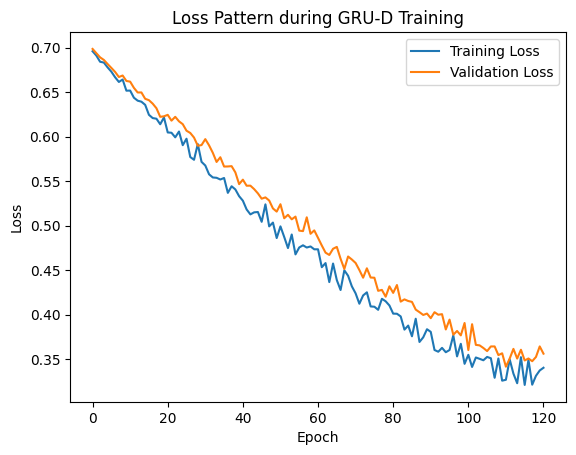

In [14]:
# Loss Pattern Plot

plt.plot(range(len(stats[2])),stats[2], label = 'Training Loss')
plt.plot(range(len(stats[2])),stats[3], label = 'Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Pattern during GRU-D Training' )

## Assessment of All Time Points

This section demonstrates assessment of all time points and comparision between GRU_D model and the baseline EWS comparitors.

Testing Loop
Plotting Matrix


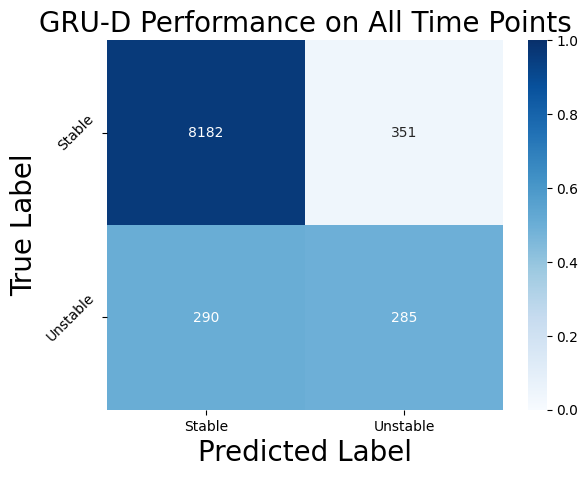

Accuracy : 0.9296
Precision: 0.4481
Specificity: 0.9589
Recall: 0.4957
Balanced Accuracy: 0.7273
Plotting ROC Curves


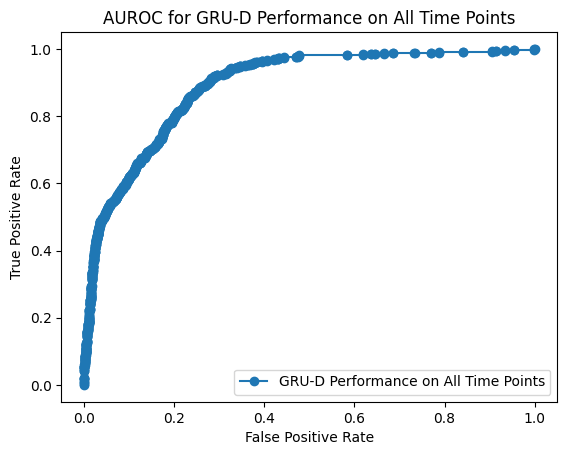

AUROC: 0.8893


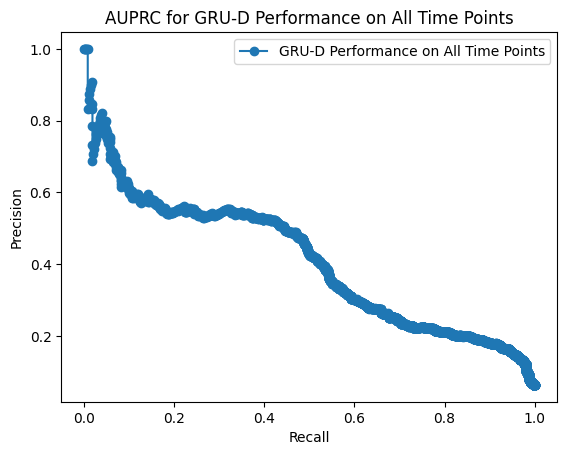

AUPRC: 0.4095


In [15]:
# With Test set extract the predictions from GRU-D.  

# Metadata required to compare against other EWS
test_episodes = episodes[test_idx[inclusion_mask]]

# Extract sequences to compare against other EWS
gru_long_probs, gru_long_pred, gru_long_labels ,gru_long_len = Test_Model(mod, gru_test_dataloader_long, 'GRU-D Performance on All Time Points', classes = ['Stable', 'Unstable'])   

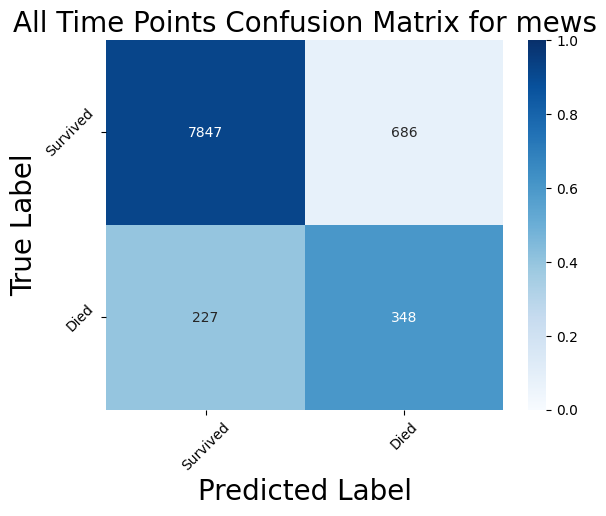

Accuracy : 0.8998
Specificity: 0.9196
Recall: 0.6052
Balanced Accuracy: 0.7624


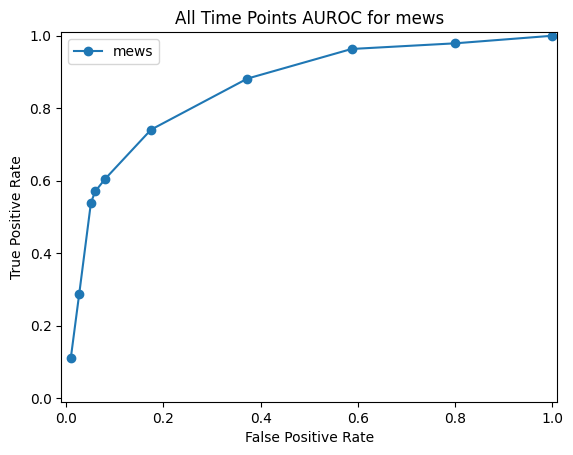

AUROC: 0.8570


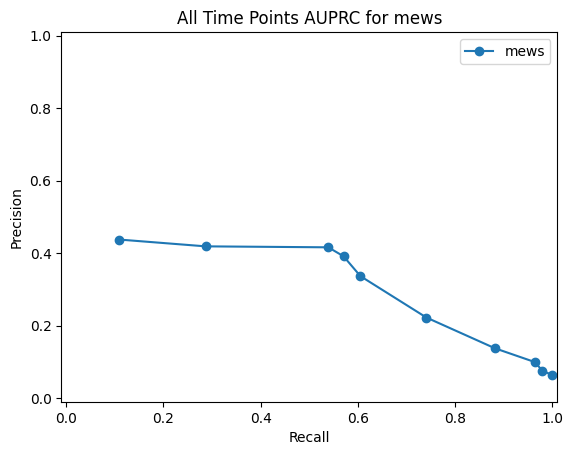

AUPRC: 0.2823


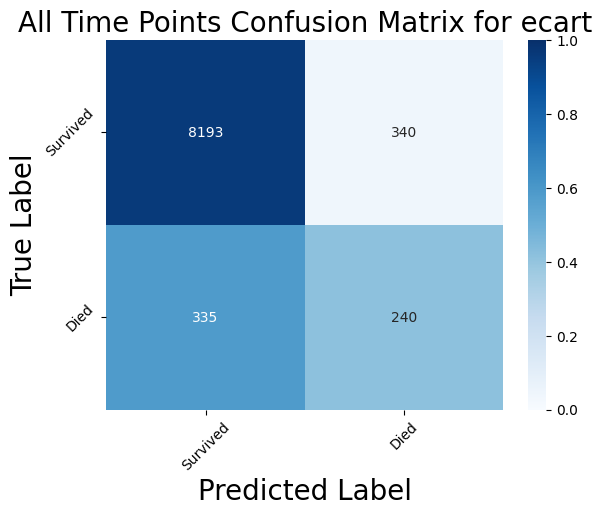

Accuracy : 0.9259
Specificity: 0.9602
Recall: 0.4174
Balanced Accuracy: 0.6888


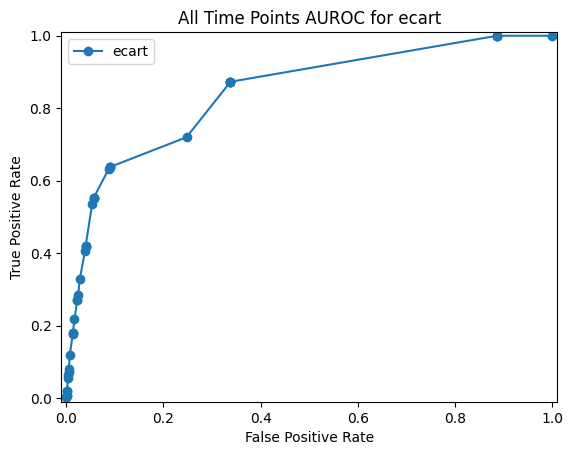

AUROC: 0.8436


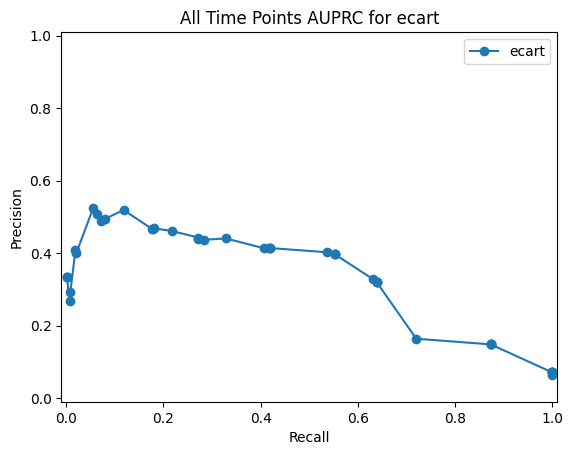

AUPRC: 0.3326


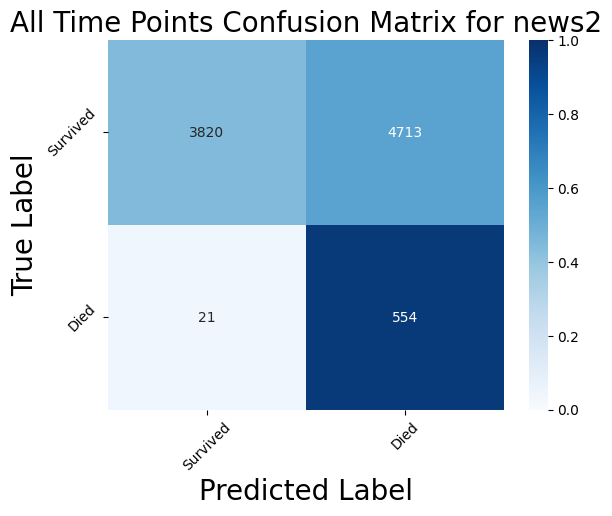

Accuracy : 0.4802
Specificity: 0.4477
Recall: 0.9635
Balanced Accuracy: 0.7056


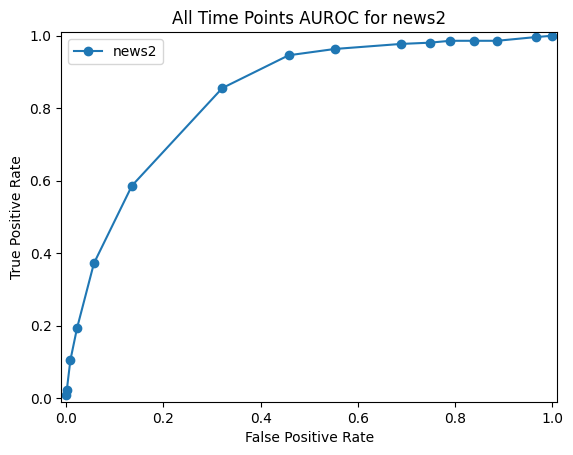

AUROC: 0.8367


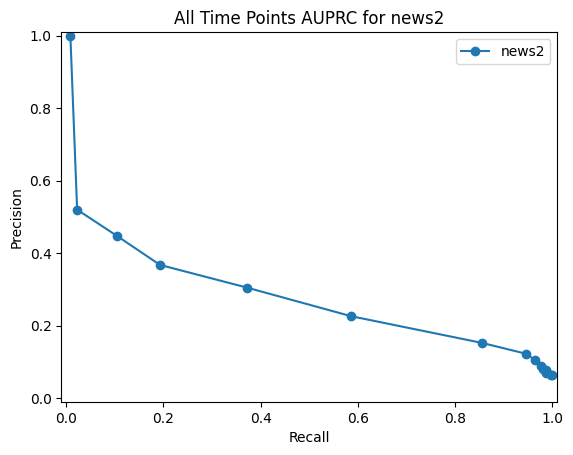

AUPRC: 0.2716


In [16]:
# Same assessment using the same episodes for MEWS, eCART and NEWS2.  Thresholds set according to original paper.

mews_long_tp_results = ews_time_point_results (df, test_episodes, 'mews', 'long')
ecart_long_tp_results = ews_time_point_results (df, test_episodes, 'ecart', 'long')
news_long_tp_results = ews_time_point_results (df, test_episodes, 'news2', 'long')

Plots of vital signs along with EWS Score/GRU-D Model Output.  Alter the t_idx to explore the different examples.  We plot two examples, the first has results in an adverse outcome, but the second does not, but still has periods of instability which are found by GRU-D Models.  There is suggestion that the use of temporal patterns are helpful as the second plot does not result in over alarming.

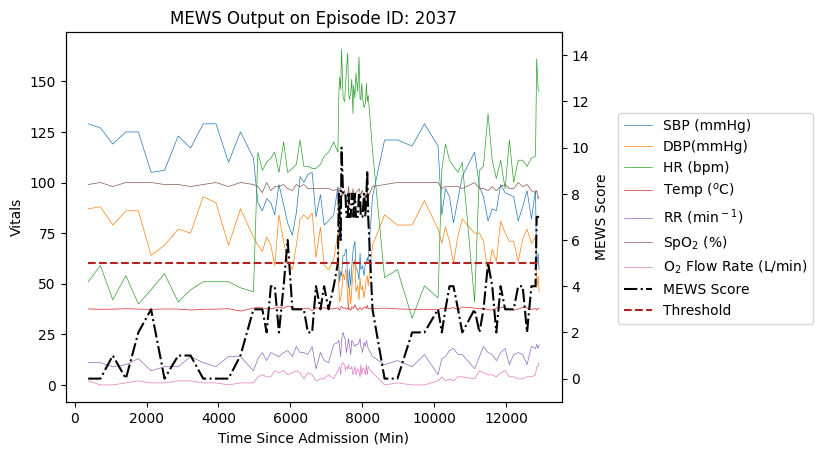

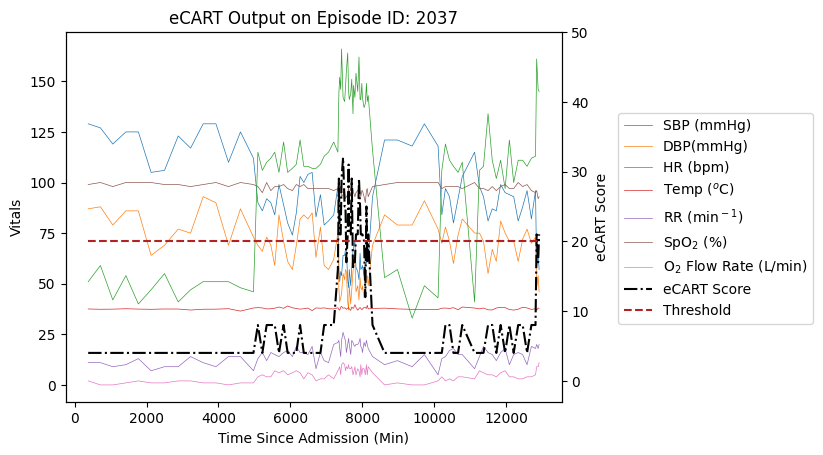

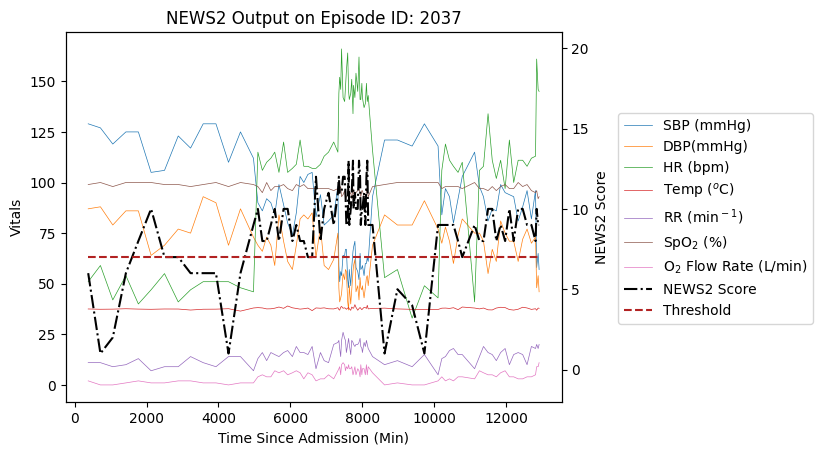

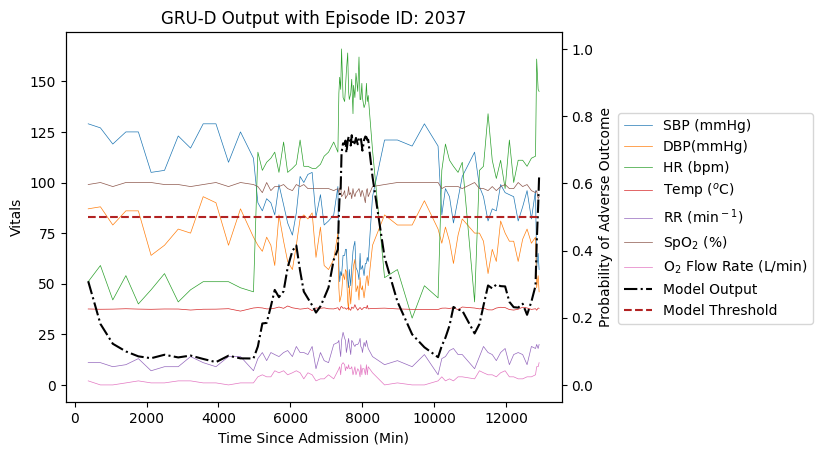

In [30]:
from plotting_func import *

# Alter t_idx to find different examples
t_idx = 16

plot_vitals_mews (df,episodes, test_idx[inclusion_mask],t_idx)
plot_vitals_ecart (df, episodes, test_idx[inclusion_mask],t_idx)
plot_vitals_news (df, episodes, test_idx[inclusion_mask],t_idx)
plot_vitals_gru_d_prob(df, episodes, test_idx[inclusion_mask], gru_long_probs, gru_long_len,t_idx)

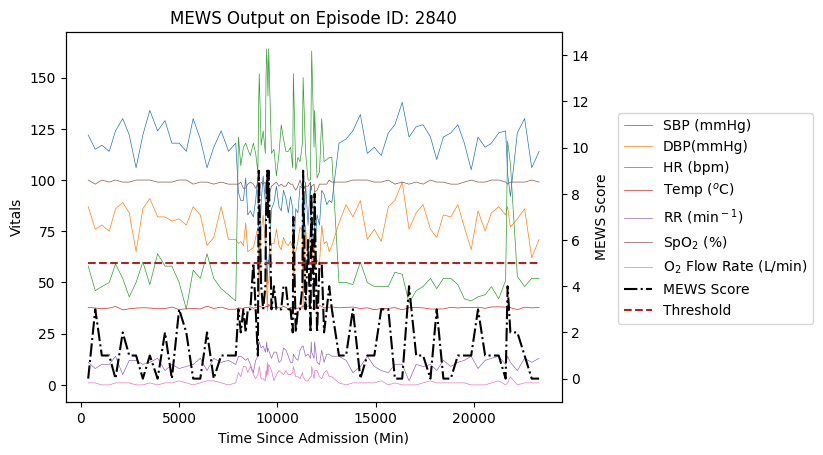

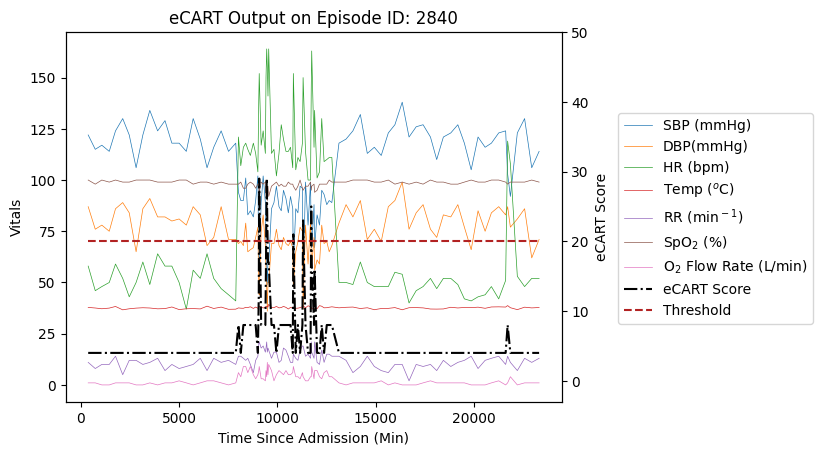

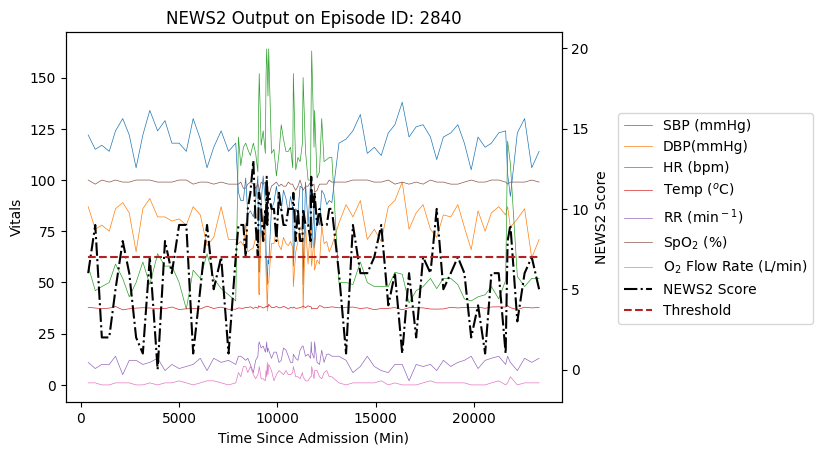

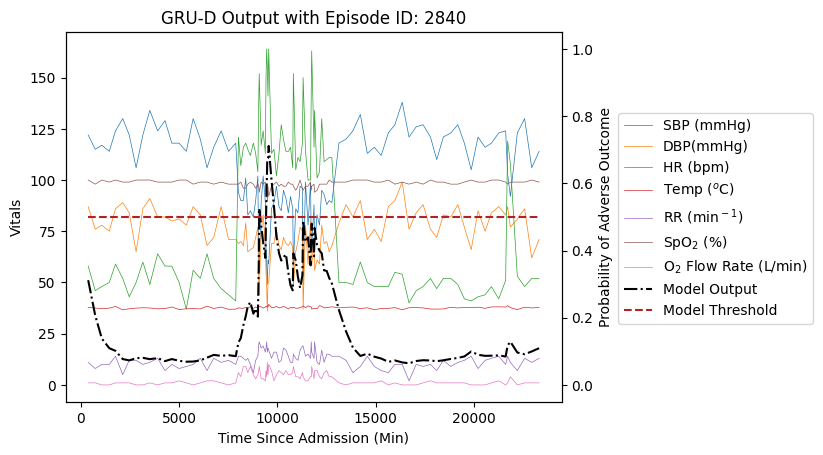

In [18]:

# Alter t_idx to find different examples
t_idx = 5

plot_vitals_mews (df, episodes, test_idx[inclusion_mask],t_idx)
plot_vitals_ecart (df, episodes, test_idx[inclusion_mask],t_idx)
plot_vitals_news (df, episodes, test_idx[inclusion_mask],t_idx)
plot_vitals_gru_d_prob(df, episodes, test_idx[inclusion_mask], gru_long_probs, gru_long_len,t_idx)

## Assessment of Last 24 hours

This section demonstrates assessment of time points within the last 24 hours and the sequence level prediction within this period.

Testing Loop
Plotting Matrix


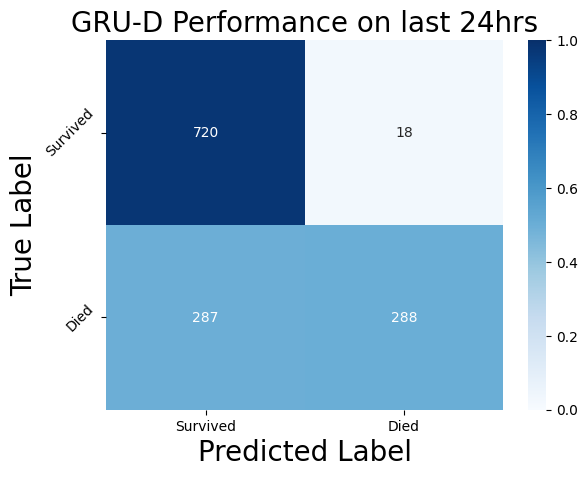

Accuracy : 0.7677
Precision: 0.9412
Specificity: 0.9756
Recall: 0.5009
Balanced Accuracy: 0.7382
Plotting ROC Curves


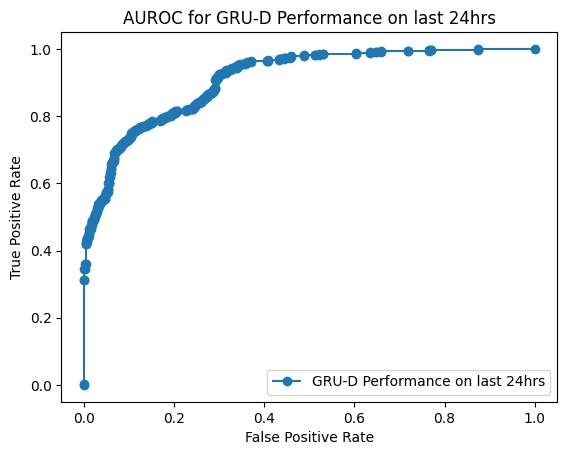

AUROC: 0.9102


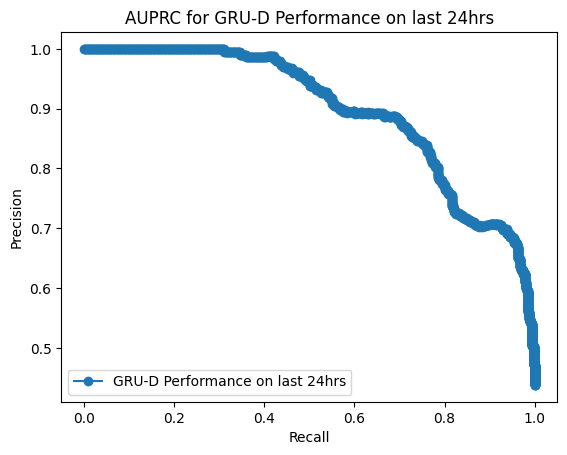

AUPRC: 0.8977


In [19]:
# Extract sequences to compare against other EWS

gru_24_probs, gru_24_pred, gru_24_labels ,gru_24_len = Test_Model(mod, gru_test_dataloader_short, 'GRU-D Performance on last 24hrs', classes = ['Survived', 'Died'])


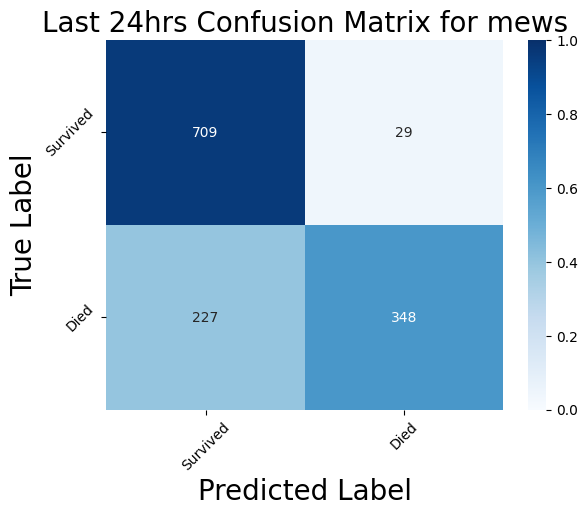

Accuracy : 0.8050
Specificity: 0.9607
Recall: 0.6052
Balanced Accuracy: 0.7830


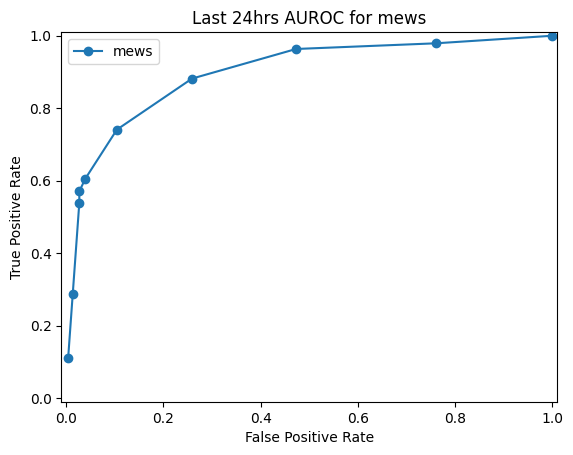

AUROC: 0.8976


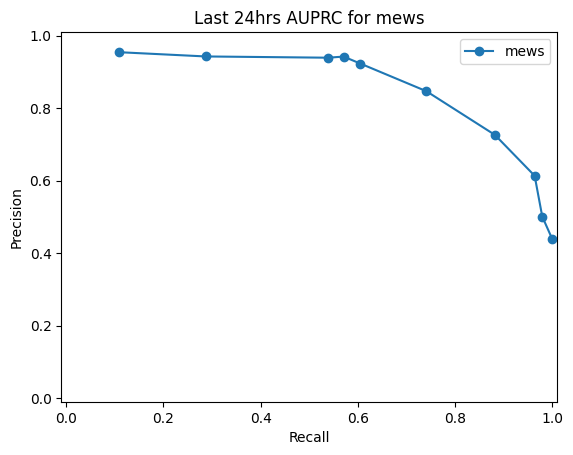

AUPRC: 0.7717


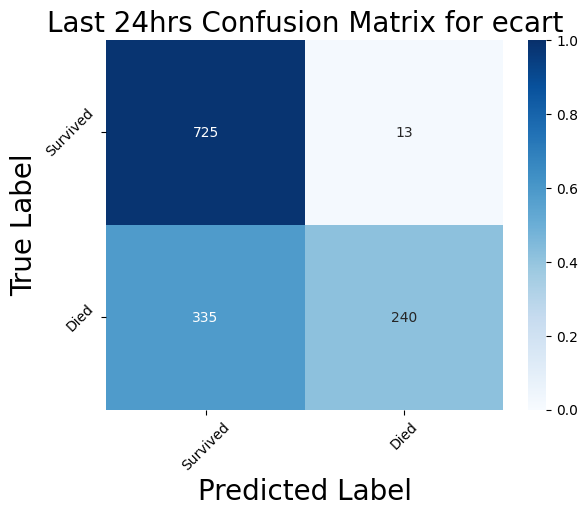

Accuracy : 0.7350
Specificity: 0.9824
Recall: 0.4174
Balanced Accuracy: 0.6999


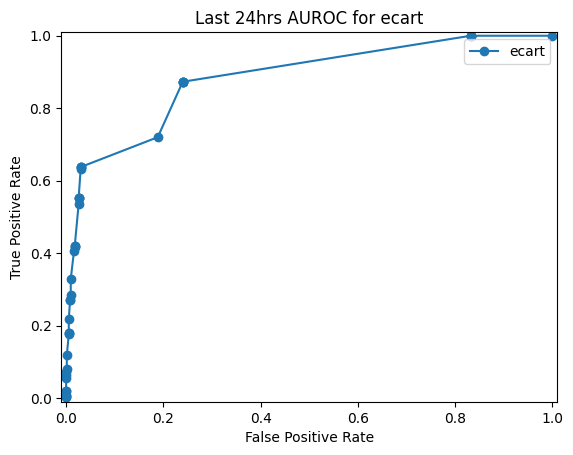

AUROC: 0.8823


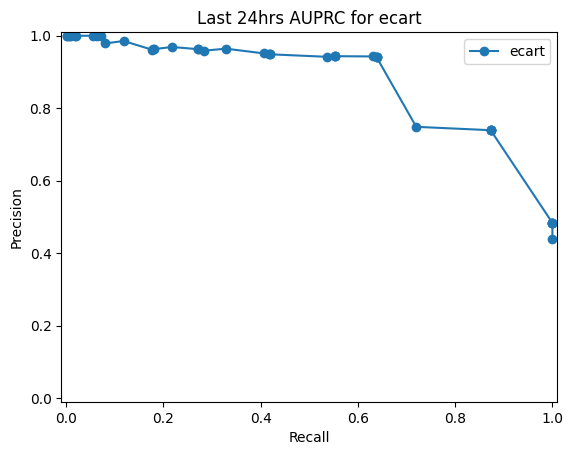

AUPRC: 0.8732


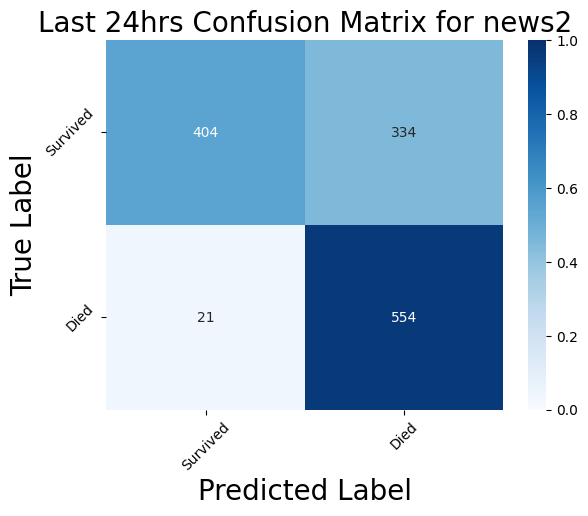

Accuracy : 0.7296
Specificity: 0.5474
Recall: 0.9635
Balanced Accuracy: 0.7555


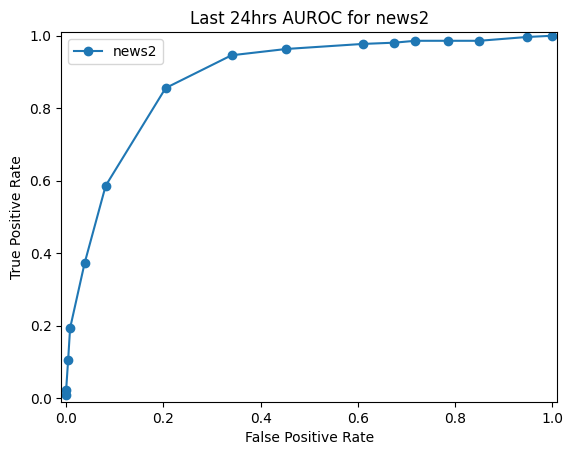

AUROC: 0.8863


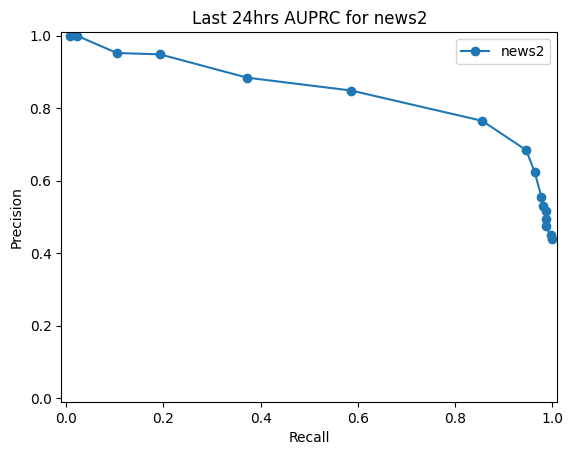

AUPRC: 0.8412


In [20]:
# Same assessment using the same episodes for MEWS, eCART and NEWS2.  Thresholds set according to original paper.

mews_short_tp_results = ews_time_point_results (df, test_episodes, 'mews', 'short')
ecart_short_tp_results = ews_time_point_results (df, test_episodes, 'ecart', 'short')
news_short_tp_results = ews_time_point_results (df, test_episodes, 'news2', 'short')

Note we should ignore the AUROC and AUPRC values as these are not representitive of the true real world use.

We now assess the EWS/GRU-D model at the sequence level.  The next section demonstrates the model's ability to identify a unwell patient within the last 24 hours

Sequence Level Prediction for mews
Specificity: 0.8926
Recall: 1.0000
Balanced Accuracy: 0.9463
Sequence Level Prediction for ecart
Specificity: 0.9597
Recall: 0.9333
Balanced Accuracy: 0.9465
Sequence Level Prediction for news2
Specificity: 0.0872
Recall: 1.0000
Balanced Accuracy: 0.5436
Sequence Level Prediction for GRU-D
Specificity: 0.9597
Recall: 0.8667
Balanced Accuracy: 0.9132


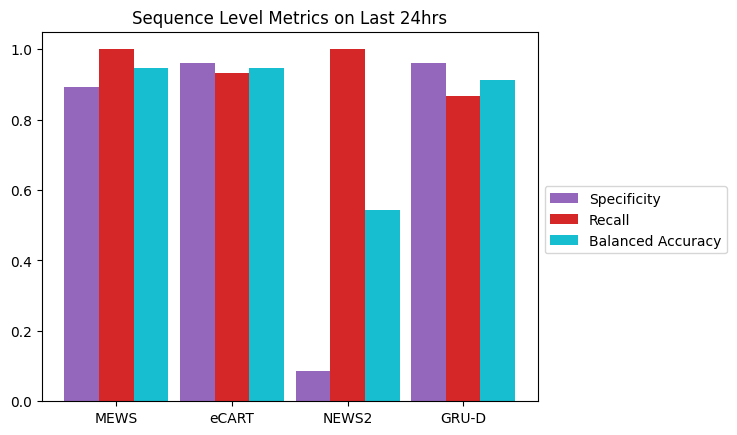

In [21]:

# This function assesses how many sequences have been correctly identified within 24 hours of an adverse event
# It is also gives a distribution of first warnings for timing assessment
mews_short_seq = ews_short_sequence_metrics(df, test_episodes, 'mews', 24)
ecart_short_seq = ews_short_sequence_metrics(df, test_episodes, 'ecart', 24)
news_short_seq = ews_short_sequence_metrics(df, test_episodes, 'news2', 24)
gru_short_seq = gru_seq_metrics (gru_24_probs, gru_24_len, gru_24_pred, gru_24_labels , last_24_timings, episodes, test_idx, inclusion_mask)

plt_labels = ['MEWS', 'eCART', 'NEWS2', 'GRU-D']
seq_results = np.zeros((4,3))

seq_results[0] = mews_short_seq[0]
seq_results[1] = ecart_short_seq[0]
seq_results[2] = news_short_seq[0]
seq_results[3] = gru_short_seq[0]

plt.bar(np.arange(4)-0.3, seq_results[:,0], width = 0.3, color = 'C4', label = 'Specificity')
plt.bar(np.arange(4), seq_results[:,1], width = 0.3, color = 'C3', label = 'Recall')
plt.bar(np.arange(4)+0.3, seq_results[:,2], width = 0.3, color = 'C9', label = 'Balanced Accuracy')
plt.xticks(np.arange(4), labels=plt_labels)
plt.title('Sequence Level Metrics on Last 24hrs')
plt.legend (bbox_to_anchor=(1, 0.6))
plt.show()


## Assessing the Timeliness of Warnings

As early warning systems, EWS and models should provide timely warnings. Using sequences that were correctly identified as within 24 hours of an adverse event.  This section plots the first warnings of each correctly identified sequence from event (i.e. the larger the better as it gives more warning time).  As these are not normally distributed, we use Mann-Whitney U pairwise tests with bonforini correction to compare the distributions of each correctly idenified sequence's first warning.

In [22]:
warnings = (mews_short_seq[1][0],  ecart_short_seq[1][0], news_short_seq[1][0], gru_short_seq[1][0])
epi_warnings = (mews_short_seq[1][1],  ecart_short_seq[1][1], news_short_seq[1][1], gru_short_seq[1][1])

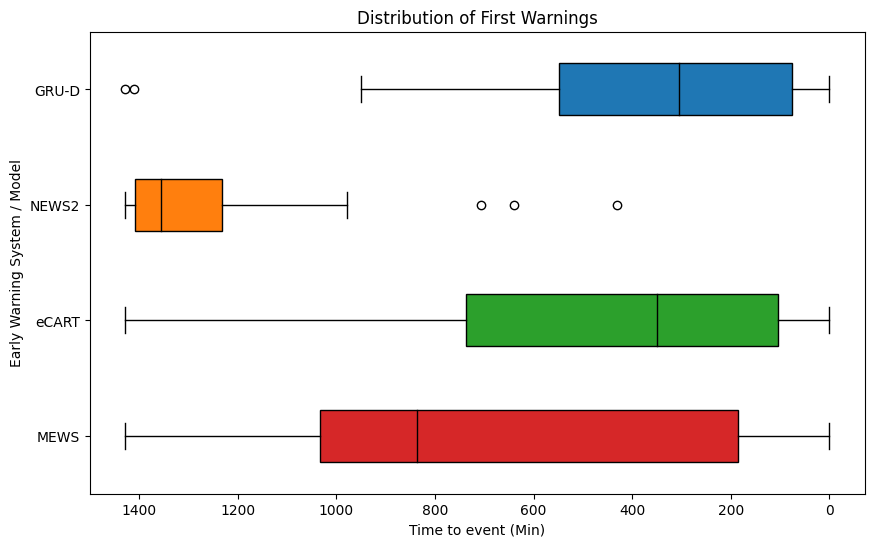

In [23]:
plt.figure(figsize= (10,6))
box = plt.boxplot(warnings,medianprops = dict(color='k'), patch_artist=True, vert = False,showfliers=True)

colors = ['C3', 'C2', 'C1', 'C0']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribution of First Warnings')
plt.yticks([1, 2, 3, 4], ['MEWS', 'eCART', 'NEWS2',  'GRU-D'])
plt.ylabel('Early Warning System / Model')
plt.xlabel('Time to event (Min)')
plt.gca().invert_xaxis()

In [24]:
print('MEWS Comparisions')
mann_whitney_comparision (warnings, epi_warnings, 'MEWS', 'eCART')
mann_whitney_comparision (warnings, epi_warnings, 'MEWS', 'NEWS2')
mann_whitney_comparision (warnings, epi_warnings, 'MEWS', 'GRU-D')

MEWS Comparisions
Pairwise Mann-Whitney-U Comparision between MEWS & eCART : 0.06760476762498478
Pairwise Mann-Whitney-U Comparision between MEWS & NEWS2 : 1.2468959742664812e-05
Pairwise Mann-Whitney-U Comparision between MEWS & GRU-D : 0.019144647516533393


0.019144647516533393

In [25]:
print('eCART Comparisions')
mann_whitney_comparision (warnings, epi_warnings, 'eCART', 'NEWS2')
mann_whitney_comparision (warnings, epi_warnings, 'eCART', 'GRU-D')

eCART Comparisions
Pairwise Mann-Whitney-U Comparision between eCART & NEWS2 : 9.597237623898034e-08
Pairwise Mann-Whitney-U Comparision between eCART & GRU-D : 0.4640918161679687


0.4640918161679687

In [26]:
print('NEWS2 Comparisions')
mann_whitney_comparision (warnings, epi_warnings, 'NEWS2', 'GRU-D')

NEWS2 Comparisions
Pairwise Mann-Whitney-U Comparision between NEWS2 & GRU-D : 2.8393073592225746e-07


2.8393073592225746e-07

A system that identifies an unwell patient close to the adverse event ($<$ four hours), while is correct, provides little lead time for clinical intervention.  This code identifies the number of first warnings that give more than 4 hours notice of an adverse event.

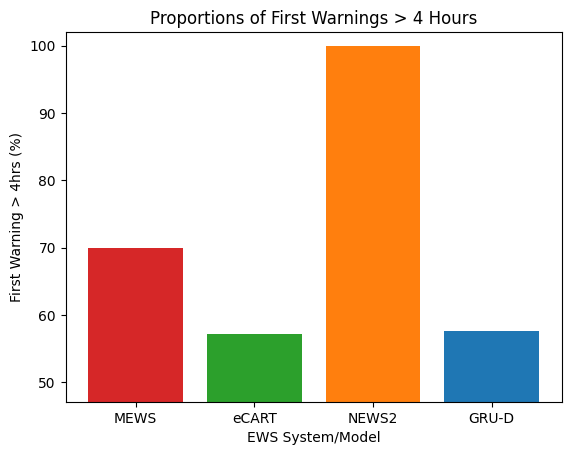

MEWS Warning proportions > 4 Hours:  70.0 %
eCART Warning proportions > 4 Hours:  57.14 %
NEWS2 Warning proportions > 4 Hours:  100.0 %
GRU-D Warning proportions > 4 Hours:  57.69 %


In [27]:
warning_proportions = np.zeros(4)
id=0
for group in warnings:
    warning_proportions[id] = ((group>240).sum() / group.shape)*100
    id+=1

l = np.array(['MEWS', 'eCART', 'NEWS2', 'GRU-D'])
plt.bar([0], warning_proportions[0], width= 0.8, label = 'MEWS', color = 'C3')
plt.bar([1], warning_proportions[1], width= 0.8, label = 'eCART', color = 'C2')
plt.bar([2], warning_proportions[2], width= 0.8, label = 'NEWS2', color = 'C1')
plt.bar([3], warning_proportions[3], width= 0.8, label = 'GRU-D', color = 'C0')

plt.ylabel('First Warning > 4hrs (%)')
plt.xlabel('EWS System/Model')
plt.title('Proportions of First Warnings > 4 Hours')

plt.xticks(range(len(l)), labels=l)
plt.ylim(warning_proportions.min() -10 ,102)
plt.show()

for i in range(4):
    print (l[i] , 'Warning proportions > 4 Hours: ' , warning_proportions[i].round(2), '%')